## Week 11 - Spatial Data Analysis 2

### Overview of Class
- Review of last week 
    - Loading in spatial data
    - Joining geodataframes with data tables
    - Plotting maps

- More on Cartography
    - Using different classification schemes
    - Adding backgrounds

- Clustering
    - What is 'clustering'?
    - How can we conceptualize clustering in space?
        - Spatial autocorrelation

- Measuring spatial autocorrelation
    - Global measures
    - Local measures
    - Using `pysal` and `splot`


    

In [130]:
## Let's install and then load libraries
import sys
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install mapclassify
!{sys.executable} -m pip install contextily
!{sys.executable} -m pip install libpysal
!{sys.executable} -m pip install esda
!{sys.executable} -m pip install splot
!{sys.executable} -m pip install xlrd


In [131]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify
import esda
import splot
import libpysal as lps
import contextily as cx
import xlrd

### Let's bring in the same files we worked with last week to get the ball rolling...

We'll be working with the Toronto Neighbourhoods spatial data and the health data today:
`Toronto_Neighbourhoods.geojson` and `1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls`

#### Let's create the geodataframe:

In [132]:
nbrhd = gpd.GeoDataFrame.from_file("Toronto_Neighbourhoods.geojson")

#### Now let's simplify the geodataframe and convert our spatial id from a string to a number:

In [133]:
#get gdf ready
important_spat_cols = nbrhd.columns[[4, 5, 17]]
colnames_spat = {important_spat_cols[0]: 'name',
           important_spat_cols[1] : 'nbrhd_spat_id',
           important_spat_cols[2] : 'geometry'}

#copy the gdf to a new gdf variable name
nbrhd_simple = nbrhd.copy()

#keep only the 'important' columns and then rename them
nbrhd_simple = nbrhd_simple[important_spat_cols]
nbrhd_simple.rename(columns = colnames_spat, inplace=True)

#create a new variable in the nbrhd_simple geodataframe and store the new number
#version of the neighbourhood id here
nbrhd_simple["Neighbid"] = nbrhd_simple["nbrhd_spat_id"].astype(int)

nbrhd_simple.head()

,name,nbrhd_spat_id,geometry,Neighbid
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103


#### Next, let's get our table with health information imported and ready to join with our gdf and then simplify the dataframe:

In [134]:
#get neighbourhood attribute data ready

fname = '1_ahd_neighb_db_ast_hbp_mhv_copd_2007.xls' #file name
sname = '1_ahd_neighb_asthma_2007' #sheet name in excel file

#store excel sheet with asthma data in a dataframe variable
asthma_neighb = pd.read_excel(fname, sheet_name = sname, header = 11)

#let's simplify this by only pulling a few relevant columns
important_cols = asthma_neighb.columns[[0, 1, 10, 11]]
colnames = {important_cols[0]: 'Neighbid', 
            important_cols[1] : 'name', 
            important_cols[2] : 'adult_pop',
            important_cols[3] : 'asthma_pct'}

asthma_rates = asthma_neighb.copy()

asthma_rates = asthma_rates[important_cols]

asthma_rates.rename(columns = colnames, inplace=True)

asthma_rates.head()



,Neighbid,name,adult_pop,asthma_pct
0,1,West Humber-Clairville,23747,10.2
1,2,Mount Olive-Silverstone-Jamestown,22619,9.1
2,3,Thistletown-Beaumond Heights,6629,10.0
3,4,Rexdale-Kipling,6755,11.4
4,5,Elms-Old Rexdale,6588,11.6


#### Finally, let's join our neighbourhood gdf with our asthma rate df:

In [135]:
#Now let's do the join!
nbrhd_simple = nbrhd_simple.merge(asthma_rates, on="Neighbid")
nbrhd_simple.head()

,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,adult_pop,asthma_pct
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,6640,10.1
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95,Annex,20869,9.5
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109,Caledonia-Fairbank,6615,11.3
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64,Woodbine Corridor,8346,13.0
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103,Lawrence Park South,9709,10.7


#### Then let's make sure we can map it:

<AxesSubplot:>

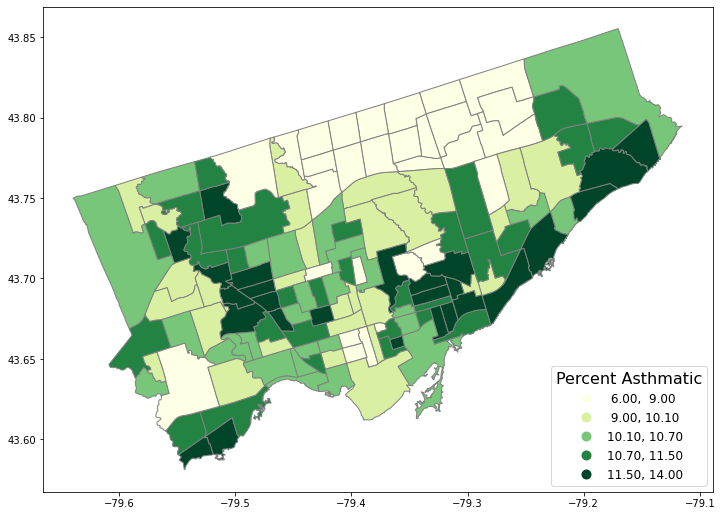

In [136]:
#first let's create a figure variable "fig" and an axes variables called "ax".
#this code sets the stage - it says how many images - by rows/columns, and we can set other
#figure attributes in here, like figure size using figsize

fig, axes = plt.subplots(1, 1, figsize = (12,12))

nbrhd_simple.plot(column='asthma_pct', scheme='quantiles', 
                  k=5, cmap='YlGn', edgecolor='grey', 
                  ax = axes, legend=True, 
                  legend_kwds={'loc': 4, 'title': 'Percent Asthmatic', 
                               'title_fontsize': 16,'fontsize': 12})

#### OK, now make a figure with two maps side by side...

<AxesSubplot:>

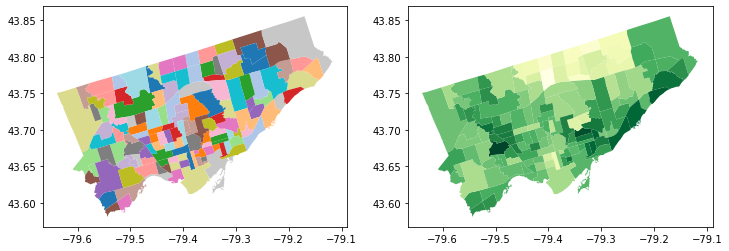

In [137]:
fig, axes = plt.subplots(1, 2, figsize = (12,12))

# pick the first cell in the figure
nbrhd_simple.plot(column = "name_x",
           ax=axes[0], cmap = "tab20")

# pick the second cell in the figure
nbrhd_simple.plot(column = "asthma_pct",
           ax=axes[1], cmap = "YlGn")



### POP QUIZ!! 

1. How would we make a figure with 3 maps in 1 row? 
2. How would we make a figure with 3 maps in 1 **column**?
3. How would we make a figure with 6 maps in 3 rows and 2 columns? 

In [ ]:
fig, axes = plt.subplots(, , figsize = (12,12))

nbrhd_simple.plot()
nbrhd_simple.plot()
nbrhd_simple.plot()

In [ ]:
fig, axes = plt.subplots(, , figsize = (12,12))

nbrhd_simple.plot()
nbrhd_simple.plot()
nbrhd_simple.plot()

In [ ]:
fig, axes = plt.subplots(, , figsize = (12,12))

nbrhd_simple.plot()
nbrhd_simple.plot()
nbrhd_simple.plot()
nbrhd_simple.plot()
nbrhd_simple.plot()
nbrhd_simple.plot()

# More on Cartography
## To this point we have used quantiles to classify values in maps. 
### What other common options do we have? 

1. Equal Intervals
- This classification method "divides the data into equal size classes (e.g., 0-10, 10-20, 20-30, etc.) and works best on data that is generally spread across the entire range. CAUTION: Avoid equal interval if your data are skewed to one end or if you have one or two really large outlier values."

2. Natural Breaks
- This classification method "is a kind of “optimal” classification scheme that finds class breaks that will minimize within-class variance and maximize between-class differences." However, these breaks will be unique to each dataset and makes it difficult to compare across different maps. 


Let's use the `scheme` parameter to the plot our asthma percentages using quartiles, equal intervals, and natural breaks. 


Text(0.5, 1.0, 'Natural Breaks')

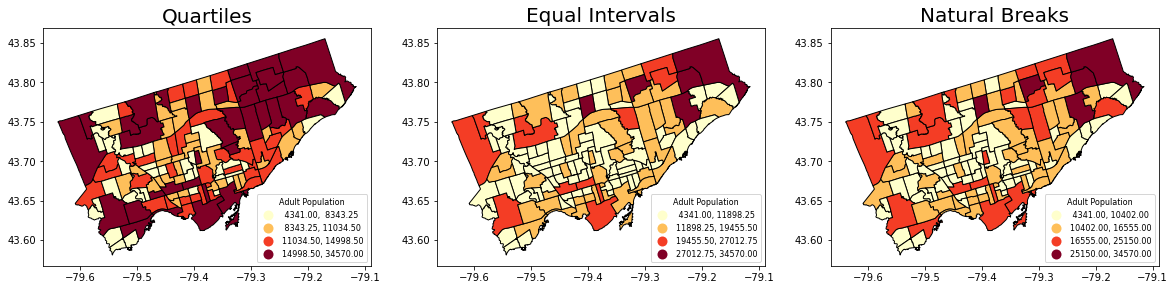

In [138]:
fig, axes = plt.subplots(1,3, figsize =  (20,10))

nbrhd_simple.plot(column='adult_pop', scheme='quantiles', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes[0], legend=True,                  
                  legend_kwds={'loc': 4, 'title': 'Adult Population', 
                               'title_fontsize': 8,'fontsize': 8})

nbrhd_simple.plot(column='adult_pop', scheme='equal_interval', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes[1], legend=True,                  
                  legend_kwds={'loc': 4, 'title': 'Adult Population', 
                               'title_fontsize': 8,'fontsize': 8})

nbrhd_simple.plot(column='adult_pop', scheme='natural_breaks', 
                  k=4, cmap='YlOrRd', edgecolor='black', 
                  ax = axes[2], legend=True,                  
                  legend_kwds={'loc': 4, 'title': 'Adult Population', 
                               'title_fontsize': 8,'fontsize': 8})

axes[0].set_title("Quartiles", fontsize = 20)
axes[1].set_title("Equal Intervals", fontsize = 20)
axes[2].set_title("Natural Breaks", fontsize = 20)


## Adding a background

What if we want to add a background to our maps? It's pretty easy!

We will use the contextily library to do this. But first we need to double check that our coordinate reference system is properly set. To layer our maps on top of a web background map, we need to make sure the projection is set to something known as "Web Mercator": https://epsg.io/3857


In [139]:
#check current crs
nbrhd_simple.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Let's reproject the map into Web Mercator and compare to the original projection:

<AxesSubplot:>

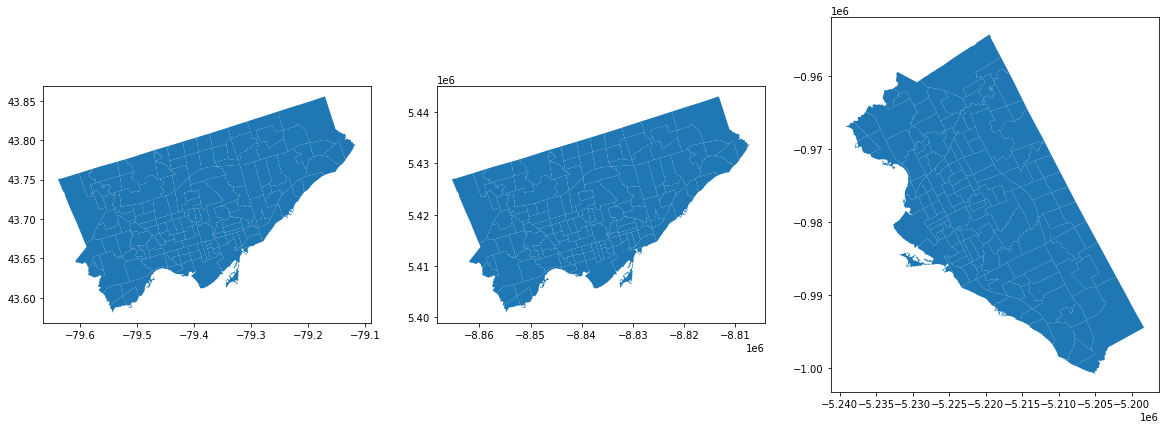

In [140]:
nbrhd_webmap = nbrhd_simple.to_crs("EPSG:3857")

#let's throw in a polar projection just for fun! 
## https://www.esri.com/arcgis-blog/products/imagery/imagery/two-views-from-the-top-of-the-world/
nbrhd_polar = nbrhd_simple.to_crs("EPSG:3995")

fig, axes = plt.subplots(1,3, figsize =  (20,10))

#original
nbrhd_simple.plot(ax = axes[0])
#web mercator
nbrhd_webmap.plot(ax = axes[1])
#polar projection
nbrhd_polar.plot(ax = axes[2])

### To add the web basemap, we can do the following

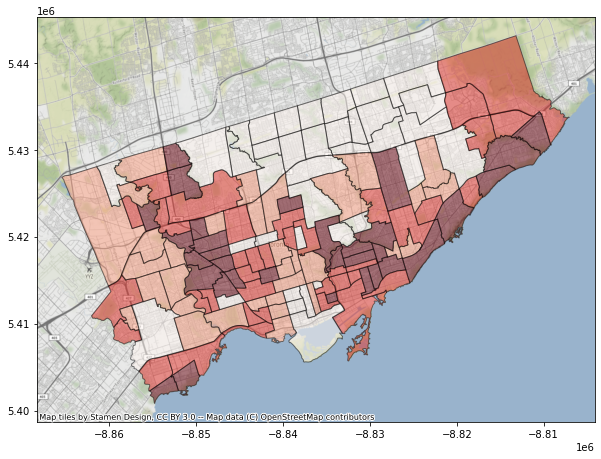

In [141]:
#alpha parameter makes the map transparent
fig, axes = plt.subplots(1,1, figsize = (10,10))

nbrhd_webmap.plot(column = "asthma_pct", scheme = "quantiles",
                  k = 4, cmap = "Reds", ax = axes,
                  alpha=0.5, edgecolor='k')

cx.add_basemap(axes)

# Clustering

## What is clustering? 

Clustering, generally, is the act of grouping similar things with eachother. We can do this with non-spatial data as well as spatial data. One common clustering method is k-means, which we won't cover in this class, but if you're interested, there's a nice tutorial on the method here: 

https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203


## Why do we want to identify clusters? 

Because clusters identify groups of data with similar attribute values, we can use it to begin to understand what **drives** the grouping. 

For example, we may have data on individuals' income outcomes and education levels (e.g., total number of years in schools, colleges, and universities). If we perform a cluster analysis, we can identify discrete groups which may be easier to work with when we want to do further analysis. These groups may be something like:

 - cluster 1: high income, more education
 - cluster 2: high income, less education
 - cluster 3: low income, less education
 - cluster 4: low income, more education
 
From there, we can look at other attributes of those clusters. This approach is commonly used in demographic analysis where many attributes are considered to create discrete clusters. A good example of this used in practice is Environics Analytics PRIZM Segmentation:

https://environicsanalytics.com/en-ca/data/segmentation

![example of different segments](https://environicsanalytics.com/images/default-source/product-pages/page-content/prizm-page-illustrations-cards.png)

[You can look up what 'demographic segment' or cluster your postal code belongs to here!](https://prizm.environicsanalytics.com/?_ga=2.84764121.114697395.1648300904-78433696.1648300904)

### Spatial clustering, at a high level, is doing the same thing but one attribute to consider is geography. 

Spatial clustering involves looking at how some attribute is expressed across space and whether similar attribute values are near eachother. 

#### If we want to do 'spatial clustering' of a variable what two pieces of information do we need? (don't over think!!!)

## Autocorrelation

Autocorrelation literally means 'self correlations'. So instead of looking at how two attributes relate to eachother, we want to explore one a single attribute relates to its neighbours.

Typically, we're talking about temporal autocorrelation or spatial autocorrelation.

## Spatial Autocorrelation

How does a variable value in a specific location correlate with the variable values in its neighbours? 

#### So again, information do we need to do answer this question?

### 1) For each observation (in this case, neighborhood) we need to know their neighbours!

To do this we can create something known as a 'weights matrix'.

A weights matrix is a matrix that describes whether or not any one observation is 'neighbours' with another.

There are many ways we can do this, but let's focus on two common ones: queens contiguity matrix and the rook contiguity matrix:

![weights matrices](https://i.stack.imgur.com/CWIHi.jpg)

### 2) Next we need to describe the value of our attribute of interest in neighbours

To do this we create a variable known as 'spatial lag'. Spatial lag for neighbourhood i is often just the average of some attribute value across all of neighbourhood i's neighbours (as determined by our weights matrix!).

### 3) Finally, now we can see how a neighbourhood's attribute compares to its neighbours. 

This set up allows us to see if neighbourhood's with high attribute values are next to other neighbourhoods with high values. We can then use a number of statistical tests to determine if there are 'significant' clusters in our dataset. 

### Let's move to some code to show how all this works.

Let's see if we have spatial clusters in:
1. the percent of adults with asthma in Toronto
2. a random column of numbers


<AxesSubplot:>

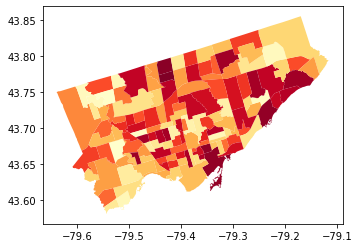

In [142]:
## Before we get going I'm going to add a column of random numbers to our nbrhd_simple gdf. 
#I'm doing this to generate a random spatial pattern in our toronto dataset. We shouldn't expect
#any spatial clusters in this random data
nbrhd_simple['randNumCol'] = np.random.randint(1, 101, nbrhd_simple.shape[0])
nbrhd_simple.plot(column = "randNumCol", cmap = 'YlOrRd')

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

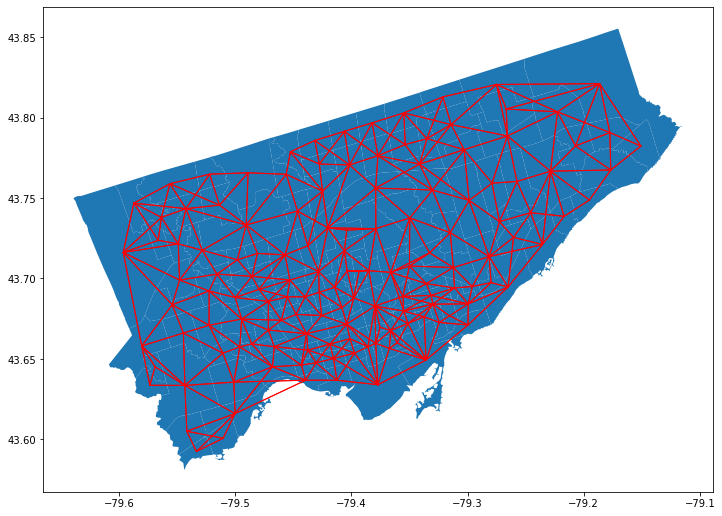

In [143]:
%%capture --no-display 
# Supress warnings because of an annoying projections issue:

# Create the spatial weights matrix
w = lps.weights.Queen.from_dataframe(nbrhd_simple)

fig, axes = plt.subplots(1,1, figsize = (12,12))

# add nbrhd map
nbrhd_simple.plot(ax = axes)

# show what weights look like
w.plot(nbrhd_simple, ax=axes, 
        edge_kws=dict(color='r', linewidth=1),
        node_kws=dict(marker=''))

### Let's inspect the weights matrix further. What does it look like: 

In [144]:
w[0] # the first location has 5 neighbours: 128, 1, 133, 134, and 55

{128: 1.0, 1: 1.0, 133: 1.0, 134: 1.0, 55: 1.0}

In [145]:
w[128] #let's see if 128 is also connected to 0...

{0: 1.0, 16: 1.0, 4: 1.0, 134: 1.0, 55: 1.0, 62: 1.0}

In [146]:
#we can also look at the distribution of connections using the built in weights histogram function.
# the first number is the count of connections and the second number is the number of neighbourhoods with
# this count of connections. For example, there are 9 nbrhds with 3 connections, 13 with 4 connections, etc.
w.histogram

[(3, 9), (4, 13), (5, 31), (6, 40), (7, 25), (8, 13), (9, 8), (10, 0), (11, 1)]

In [147]:
# finally let's 'row standardize' our matrix so that each nbrhd's connections sum to one:
# Row standardize the matrix
w.transform = 'R'

#how did this change things?
print('weights for nbrhd 0: ', w[0])
print('weights for nbrhd 128: ', w[128])

weights for nbrhd 0:  {128: 0.2, 1: 0.2, 133: 0.2, 134: 0.2, 55: 0.2}
weights for nbrhd 128:  {0: 0.16666666666666666, 16: 0.16666666666666666, 4: 0.16666666666666666, 134: 0.16666666666666666, 55: 0.16666666666666666, 62: 0.16666666666666666}


### Now that we have spatial weights established, we can calculate spatial lag.

Let's do that for asthma_pct and for randNumCol

In [148]:
# calculate the average of asthma_pct attribute of neighbours, then store in a new column
nbrhd_simple['w_asthma_pct'] = lps.weights.lag_spatial(w, nbrhd_simple['asthma_pct'])
nbrhd_simple.head()

,name_x,nbrhd_spat_id,geometry,Neighbid,name_y,adult_pop,asthma_pct,randNumCol,w_asthma_pct
0,Casa Loma (96),096,"POLYGON ((-79.41469 43.67391, -79.41485 43.674...",96,Casa Loma,6640,10.1,68,10.480000
1,Annex (95),095,"POLYGON ((-79.39414 43.66872, -79.39588 43.668...",95,Annex,20869,9.5,60,9.788889
2,Caledonia-Fairbank (109),109,"POLYGON ((-79.46021 43.68156, -79.46044 43.681...",109,Caledonia-Fairbank,6615,11.3,82,11.150000
3,Woodbine Corridor (64),064,"POLYGON ((-79.31485 43.66674, -79.31660 43.666...",64,Woodbine Corridor,8346,13.0,57,11.825000
4,Lawrence Park South (103),103,"POLYGON ((-79.41096 43.70408, -79.41165 43.703...",103,Lawrence Park South,9709,10.7,32,10.200000


<AxesSubplot:xlabel='asthma_pct', ylabel='w_asthma_pct'>

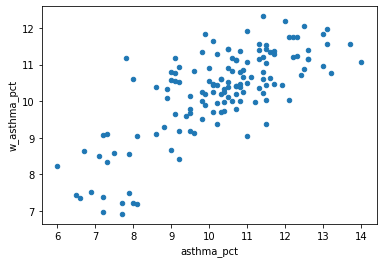

In [149]:
#let's look at a scatter plot between asthma_pct in each neighbourhood vs. the avg asthma_pct in their neighbors
nbrhd_simple.plot.scatter(x = "asthma_pct", y = "w_asthma_pct")

<AxesSubplot:xlabel='randNumCol', ylabel='w_randNumCol'>

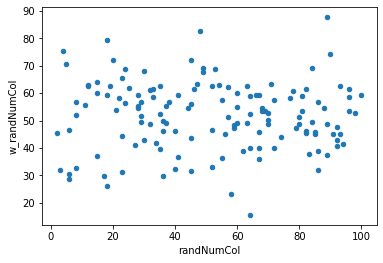

In [150]:
### Let's repeat the above, but for our random number column we created.
nbrhd_simple['w_randNumCol'] = lps.weights.lag_spatial(w, nbrhd_simple['randNumCol'])
nbrhd_simple.plot.scatter(x = "randNumCol", y = "w_randNumCol")

## So what do we see in the above two scatterplots?

#### Prompt:
As 'asthma_pct' in a specific neighbourhood gets larger, the average value of 'asthma_pct' in that neighbhourhood's neighbours *(gets smaller/gets bigger/doesn't change)*.

#### Prompt: 
As 'randNumCol' in a specific neighbourhood gets larger, the average value of 'randNumCol' in that neighbhourhood's neighbours *(gets smaller/gets bigger/doesn't change)*.

## Moran's I
Moran's I is global spatial autocorrelation statistic that tells us if high values are next to high values and low values are next to low values. There is also a way to determine if this occurs at a significan level - e.g., does this sorting happen more than expected if the values were randomly spread across our study area.

The value of Moran's I ranges from -1 to 1, where I of 1 is perfectly clustered and -1 is perfectly 'dispersed'

![example of morans I](https://static.cambridge.org/binary/version/id/urn:cambridge.org:id:binary:20200421144010724-0711:9781108614528:49898fig4_1.png)

**Ho = the values of asthma_pct are randomly distributed across our study area**

**Ha = the values of asthma_pct are not randomly distributed (aka we have spatial clusters in our study area)** 

If our p value is < 0.05 we will reject our null hypothesis Ho

The Morans I value is:  0.5478579432852013
The p-value of this Morans I value is:  0.001


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (0.55)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

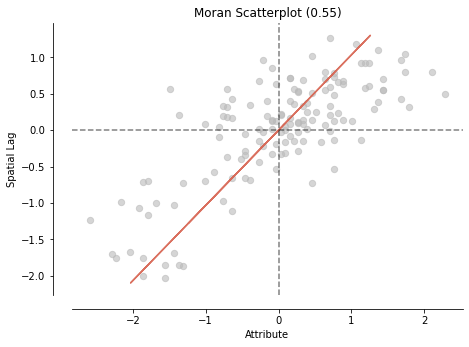

In [151]:
mi = esda.Moran(nbrhd_simple['asthma_pct'], w)

print('The Morans I value is: ', mi.I)
print('The p-value of this Morans I value is: ', mi.p_sim)

#visualize!
splot.esda.moran_scatterplot(mi)

The Moran's plot shows us the same scatter we saw before except now they've standardized the variable value and the spatial lag values (aka made them z-scores, where 0 is average). 

We can break the scatterplot into 4 quadrants - going counter clockwise, starting from the upper-right. 

1. The upper right is the 'high-high' quadrant, where high values in a nbrhd are next to neighbours with high values (quadrant 1)
2. The upper left is the 'low-high' quadrant, where low values in a nbrhd are next to neighbours with high values (quadrant 2)
3. The lower left is the 'low-low' quadrant (quadrant 3)
4. The lower right is the 'high-low' quadrant (quadrant 4)


If most points in our scatterplot are in the high-high and low-low quadrants we probably have clustering. If they are mostly in the low-high and high-low then there's likely dispersal. If there is no obvious pattern, then there's probably no clustering!

### Let's do it again with the random numbers column

The Morans I value is:  -0.009791605654871523
The p-value of this Morans I value is:  0.481


(<Figure size 504x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Moran Scatterplot (-0.01)'}, xlabel='Attribute', ylabel='Spatial Lag'>)

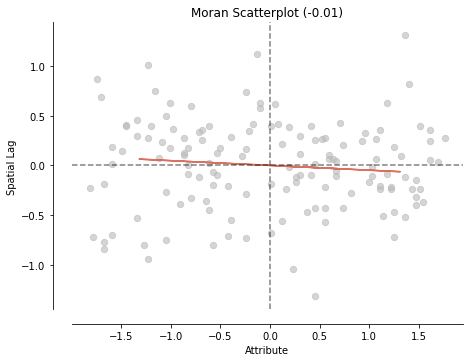

In [152]:
mi_randNumCol = esda.Moran(nbrhd_simple['randNumCol'], w)

print('The Morans I value is: ', mi_randNumCol.I)
print('The p-value of this Morans I value is: ', mi_randNumCol.p_sim)

#visualize!
splot.esda.moran_scatterplot(mi_randNumCol)

## Local Spatial Autocorrelation

### OK, that's great, but WHERE are the clusters? 

We can use a different statistic to identify significant incidents of local spatial autocorrelation. This tells us exactly where on the map this clustering is happening!

We can think about the Moran's I plots to help us here. Using a new function we can identify which quadrant each neighbourhood is in, and if the relationship to neighbourhing values is strong enough to be significant. 

Those observations in quadrant 1 and 3 are 'clustered' and those in 2 and 4 would be 'outliers'. 

In [154]:
lisa = esda.Moran_Local(nbrhd_simple['asthma_pct'], w)
# Break observations into significant or not
nbrhd_simple['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
nbrhd_simple['quadrant'] = lisa.q
nbrhd_simple[['asthma_pct','w_asthma_pct','significant','quadrant']].head(20)

,asthma_pct,w_asthma_pct,significant,quadrant
0,10.1,10.480000,False,2
1,9.5,9.788889,False,3
2,11.3,11.150000,False,1
3,13.0,11.825000,True,1
4,10.7,10.200000,False,4
5,7.1,8.500000,True,3
6,6.7,8.637500,True,3
7,10.8,10.477778,False,1
8,10.0,10.916667,False,2
9,11.3,11.560000,True,1


### We can use a built in function to plot the results, but this map is kind of ugly...

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

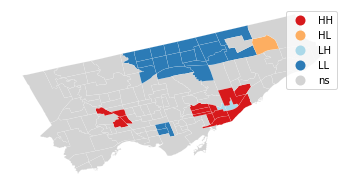

In [155]:
splot.esda.lisa_cluster(lisa, nbrhd_simple)

Text(0.5, 1.0, 'Adult Asthma Percentages')

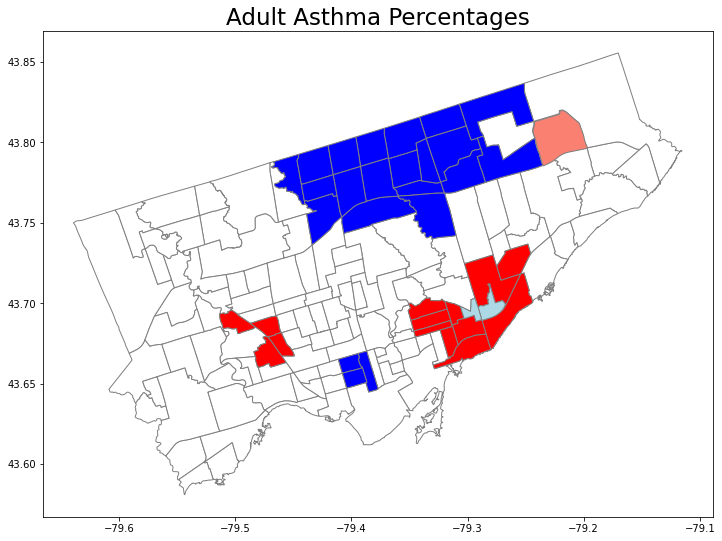

In [156]:
# Setup the figure and axis
fig, axes = plt.subplots(1,1, figsize=(12, 12))

# Plot insignificant clusters
ns = nbrhd_simple.loc[nbrhd_simple['significant']==False, 'geometry']
ns.plot(ax=axes, color='white', edgecolor='grey')

# Plot HH clusters
hh = nbrhd_simple.loc[(nbrhd_simple['quadrant']==1) & (nbrhd_simple['significant']==True), 'geometry']
hh.plot(ax=axes, color='red', edgecolor='grey')

# Plot LL clusters
ll = nbrhd_simple.loc[(nbrhd_simple['quadrant']==3) & (nbrhd_simple['significant']==True), 'geometry']
ll.plot(ax=axes, color='blue', edgecolor='grey')

# Plot LH clusters
lh = nbrhd_simple.loc[(nbrhd_simple['quadrant']==2) & (nbrhd_simple['significant']==True), 'geometry']
lh.plot(ax=axes, color='lightblue', edgecolor='grey')

# Plot HL clusters
hl = nbrhd_simple.loc[(nbrhd_simple['quadrant']==4) & (nbrhd_simple['significant']==True), 'geometry']
hl.plot(ax=axes, color='salmon', edgecolor='grey')


# Style and draw
axes.set_title("Adult Asthma Percentages", fontsize = 23)

## Finally, one more built in plot if you want!

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

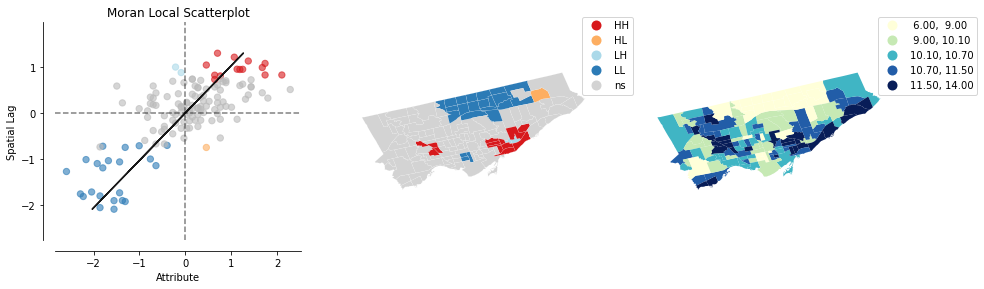

In [158]:
splot.esda.plot_local_autocorrelation(lisa, nbrhd_simple, 'asthma_pct')

## Finally finally, let's look at what the random number col looks like...

(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

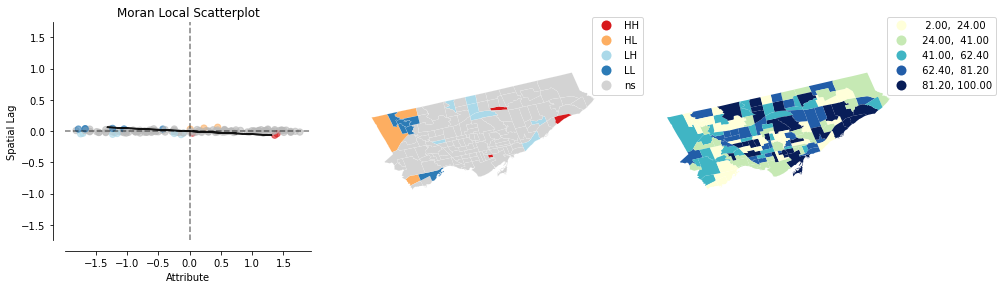

In [159]:
lisa_randNumCol = esda.Moran_Local(nbrhd_simple['randNumCol'], w)
splot.esda.plot_local_autocorrelation(lisa_randNumCol, nbrhd_simple, 'randNumCol')

### What's up with that!!! 

Even random distributions of data across space will sometime generate local clusters.

It's always good to consider the GLOBAL and LOCAL measures of spatial autocorrelation...